In [3]:
%load_ext autoreload
%autoreload 2

import os

from newspaper import Article
import newspaper
import spacy
import csv
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt
import random

# import local modules
from utils import *

!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter serverextension enable voila --sys-prefix

import ipywidgets as widgets
from IPython.display import display, clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling: voila
- Writing config: /home/murnanedaniel/miniconda3/envs/topicDetect/etc/jupyter
    - Validating...
      voila 0.3.3 OK


# Topic Detection

## Roadmap

1. Load some articles
2. Cluster in space
3. Identify a cluster C 
4. Identify the topic T of C
5. Search for other articles with the same topic T using Google API
6. Get the summaries of all these articles
7. Re-cluster the full topic T
8. For each day of the articles, build two clusters, representing perspectives P1 and P2
9. Get representative articles for each perspective PA1 and PA2

### Authenticate

In [4]:
open_api_key = widgets.Text(placeholder='Enter your OpenAI API key here', description='OpenAI API key', value=None)
google_api_key = widgets.Text(placeholder='Enter your Google API key here', description='Google API key', value=None)

In [11]:
open_api_key

Text(value='', description='OpenAI API key', placeholder='Enter your OpenAI API key here')

In [7]:
google_api_key

Text(value='', description='Google API key', placeholder='Enter your Google API key here')

In [8]:
openai.api_key(open_api_key.value)

TypeError: 'NoneType' object is not callable

## Build Article List

In [12]:
seed_topic = widgets.Text(placeholder='Enter a seed topic here', description='Seed topic', value="Ukraine")
seed_topic

Text(value='Ukraine', description='Seed topic', placeholder='Enter a seed topic here')

In [13]:
seed_search_results = get_news_results(seed_topic.value, google_api_key, recency=14)
seed_search_results = [result["link"] for result in random.sample(seed_search_results, 10)]

TypeError: get_news_results() got multiple values for argument 'recency'

In [17]:
seed_articles = [Article(url) for url in seed_search_results]

In [18]:
smh_paper = newspaper.build('https://www.smh.com.au', memoize_articles=False)

In [19]:
num_random = 30
random_articles = smh_paper.articles[:num_random]

Download and parse ("digest") the article:

In [20]:
sample_articles = seed_articles + random_articles

In [21]:
sample_articles = parse_articles(sample_articles)

100%|██████████| 40/40 [00:18<00:00,  2.21it/s]


In [22]:
sample_articles = interpret_articles(sample_articles)
sample_articles = interpret_articles(sample_articles)

100%|██████████| 40/40 [00:00<00:00, 665.23it/s]


In [ ]:
print(sample_articles)

In [23]:
article_embeddings = embed_articles(sample_articles)

In [24]:
X = np.stack(article_embeddings)

In [25]:
print("X shape:", X.shape)

(40, 2048)

## Visualize

In [26]:
pca = PCA(n_components=2)
articles2d = pca.fit_transform(X)

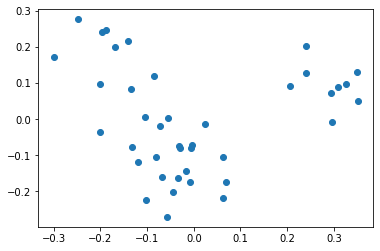

In [27]:
# plot the result
plt.scatter(articles2d[:, 0], articles2d[:, 1])

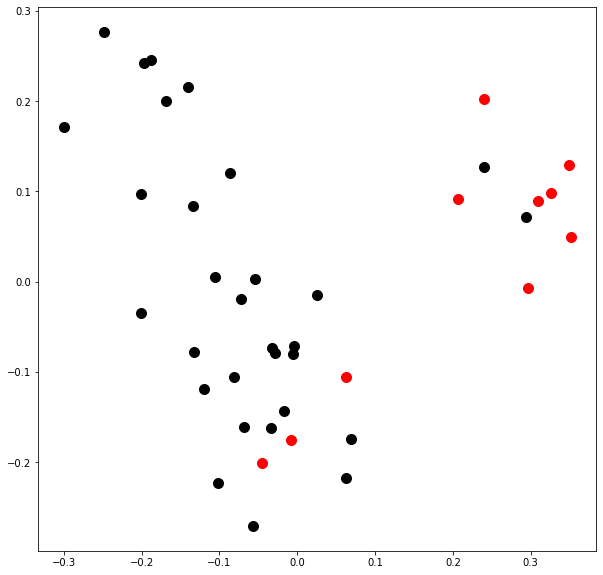

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
for article in articles2d[:len(seed_articles)]:
    ax.scatter(article[0], article[1], s=100, c="r")
for article in articles2d[len(seed_articles):]:
    ax.scatter(article[0], article[1], s=100, c="k")

## Predict Clusters

In [30]:
from sklearn.cluster import DBSCAN

In [115]:
clustering = DBSCAN(eps=0.7, min_samples=3).fit(X)

In [116]:
print(clustering.labels_)

array([-1,  0,  0, -1, -1,  0,  0, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1])

In [35]:
print([(article.title, article.source_url) for article in sample_articles])

[("Ukraine war: Minister who took in refugee says friendship will 'last lifetime' - but there are issues with scheme",
  'https://news.sky.com'),
 ('White House says the US has evidence that the war against Ukraine has been ‘a strategic disaster’ – as it happened',
  'https://www.theguardian.com'),
 ('NATO says Ukraine to decide on peace deal with Russia — within limits',
  'https://www.washingtonpost.com'),
 ('Are you a robot?', 'https://www.bloomberg.com'),
 ('Why Europe Needs Ukraine', 'https://www.theatlantic.com'),
 ('New study lists Asian countries that will be hit hardest — and least — by the Ukraine war',
  'https://www.cnbc.com'),
 ('Ukraine war: Can Russia’s promise of fewer attacks be trusted?',
  'https://www.aljazeera.com'),
 ("Ukraine’s 'iron general' is a hero, but he's no star",
  'https://www.politico.com'),
 ('Ukraine War: Putin demands Mariupol surrender to end shelling',
  'https://www.bbc.com'),
 ("Ukraine war: Putin has 'achieved zero' and Ukraine can 'absolutely'

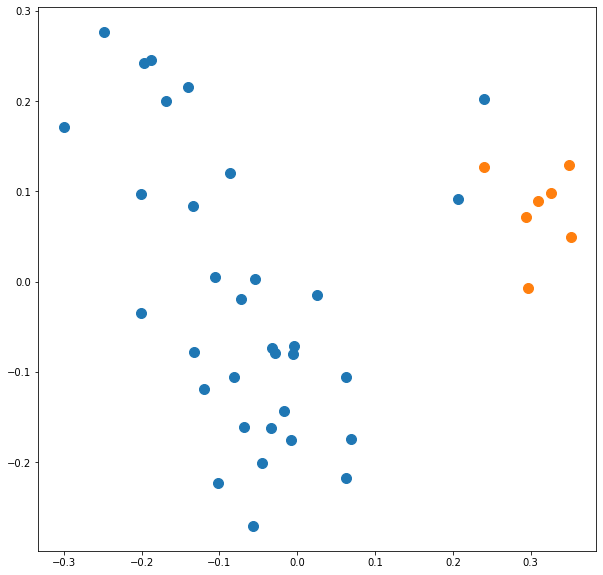

In [117]:
fig, ax = plt.subplots(figsize=(10,10))
for label in np.unique(clustering.labels_):
    article_list = articles2d[clustering.labels_ == label]
    ax.scatter(article_list[:, 0], article_list[:, 1], s=100)

In [43]:
cluster_av = np.mean(X[clustering.labels_ == 0], axis=0)

In [44]:
distances = np.sqrt(np.sum((cluster_av - X)**2, axis=1))

In [45]:
print(distances)

array([0.69995803, 0.4363709 , 0.41737965, 0.69643295, 0.63490156,
       0.49350929, 0.43200147, 0.57941439, 0.72384911, 0.4012232 ,
       0.74236843, 0.63605343, 0.65292339, 0.72000431, 0.65802432,
       0.50485397, 0.67316429, 0.70650591, 0.70265069, 0.68094762,
       0.78565148, 0.75280014, 0.71334311, 0.75570687, 0.68317702,
       0.7284396 , 0.78794332, 0.81645252, 0.79116268, 0.4457729 ,
       0.75428218, 0.73825294, 0.74578815, 0.71547393, 0.72709584,
       0.73942693, 0.81050177, 0.78899793, 0.7656575 , 0.74741011])

## Get Topic of Cluster

In [46]:
# Get sample_articles where clustering == 0
cluster_titles = ". ".join([article.title for article in sample_articles if clustering.labels_[sample_articles.index(article)] == 0])

In [47]:
topic = get_topic(cluster_titles, "text-davinci-002")

In [48]:
cluster_label = topic["choices"][0]["text"].replace("\n", "")

In [54]:
cluster_topics = []
for label in np.unique(clustering.labels_)[1:]:
    cluster_titles = ". ".join([article.title for article in sample_articles if clustering.labels_[sample_articles.index(article)] == label])
    topic = get_topic(cluster_titles, "text-davinci-002")
    cluster_topics.append(topic["choices"][0]["text"].replace("\n", ""))

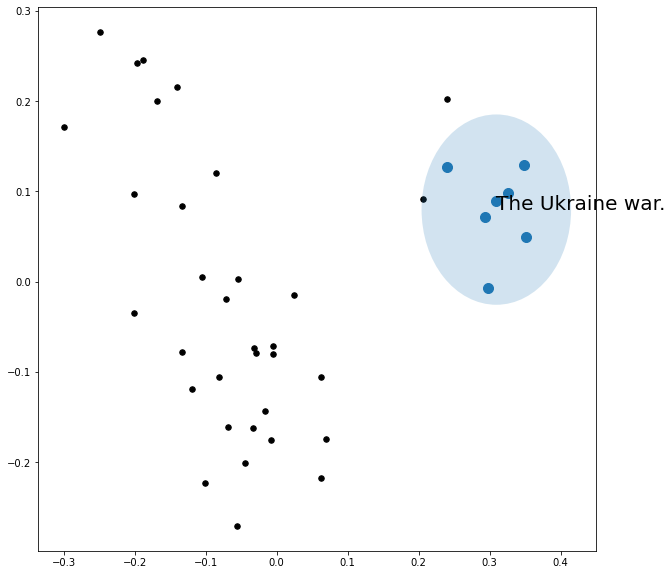

In [64]:
fig, ax = plt.subplots(figsize=(10,10))

noise_article_list = articles2d[clustering.labels_ == -1]
ax.scatter(noise_article_list[:, 0], noise_article_list[:, 1], s=30, c="k")

for label, topic in zip(np.unique(clustering.labels_)[1:], cluster_topics):
    article_list = articles2d[clustering.labels_ == label]
    ax.scatter(article_list[:, 0], article_list[:, 1], s=100)
    # Plot cluster_label text in center of cluster
    ax.text(article_list[:, 0].mean(), article_list[:, 1].mean(), cluster_label, fontsize=20)
    # Draw a circle around all points in article_list
    circle_center = article_list[:, 0].mean(), article_list[:, 1].mean()
    distances_from_mean = np.sqrt(np.sum((article_list - circle_center)**2, axis=1))
    circle_radius = distances_from_mean.max() * 1.2
    ax.add_patch(plt.Circle((article_list[:, 0].mean(), article_list[:, 1].mean()), radius=circle_radius, alpha=0.2))



## Find Related Articles

Get the keywords of the articles

In [92]:
cluster_topic = cluster_topics[0]

In [93]:
print(f"Let's focus on the first cluster topic: {cluster_topic}")

Let's focus on the first cluster topic: Ukraine War


In [67]:
cluster_articles = [article for article in sample_articles if clustering.labels_[sample_articles.index(article)] == 0]

In [68]:
# Aggregate all article keywords
cluster_keyword_list = [article.keywords for article in cluster_articles]

In [69]:
# Flatten list of lists
cluster_keyword_list = [keyword for sublist in cluster_keyword_list for keyword in sublist]

In [70]:
recency = 60
related_news_results = get_news_results(cluster_label, google_api_key, recency=recency)

In [71]:
len(related_news_results)

100

In [72]:
print(f"Found {len(related_news_results)} related news results")

Found 100 related news results


In [73]:
# Make Article list from related_news_results
related_news_articles = [Article(related_news_result["link"]) for related_news_result in related_news_results]

In [74]:
# Parse and interpret articles
related_news_articles = parse_articles(related_news_articles)
related_news_articles = interpret_articles(related_news_articles)

 42%|████▏     | 42/100 [00:31<00:50,  1.15it/s]

<newspaper.article.Article object at 0x7f0585af1100> could not be downloaded


 68%|██████▊   | 68/100 [00:48<00:16,  1.89it/s]

<newspaper.article.Article object at 0x7f0585b08580> could not be downloaded


 84%|████████▍ | 84/100 [01:01<00:15,  1.04it/s]

<newspaper.article.Article object at 0x7f0585b0a280> could not be downloaded


 85%|████████▌ | 85/100 [01:01<00:11,  1.32it/s]

<newspaper.article.Article object at 0x7f0585b0a400> could not be downloaded


 88%|████████▊ | 88/100 [01:03<00:06,  1.76it/s]

<newspaper.article.Article object at 0x7f0585b0a700> could not be downloaded


 94%|█████████▎| 89/95 [00:00<00:00, 312.98it/s]

Ukraine war: one possible casualty may be Beijing’s economic relationship with Kyiv could not be summarized
 could not be processed
 could not be processed
Live Coverage of Ukraine could not be summarized
 could not be processed
 could not be processed


In [141]:
all_articles = sample_articles + related_news_articles

In [76]:
average_article_summary_length = np.mean([len(article.summary.split(" ")) for article in related_news_articles])

In [77]:
average_article_summary_length

93.89887640449439

In [85]:
print(f"We need to be a little careful with using GPT-3. We will be embedding {len(related_news_articles)} articles, and the average article summary length is {average_article_summary_length:,.2f} tokens.")
print(f"The engine we are using costs ~1c per 1k tokens, therefore {len(related_news_articles)} articles will cost ~${len(related_news_articles) * average_article_summary_length / 1000 / 100:,.2f}. I.e. Don't run this step for fun!")

We need to be a little careful with using GPT-3. We will be embedding 89 articles, and the average article summary length is 93.90 tokens.
The engine we are using costs ~1c per 1k tokens, therefore 89 articles will cost ~$0.08. I.e. Don't run this step for fun!


In [86]:
# Embed articles
related_news_embeddings = embed_articles(related_news_articles)

In [87]:
# Visualise in PCA related embeddings
related_news_embeddings = np.stack(related_news_embeddings)
related_articles2d = pca.transform(related_news_embeddings)

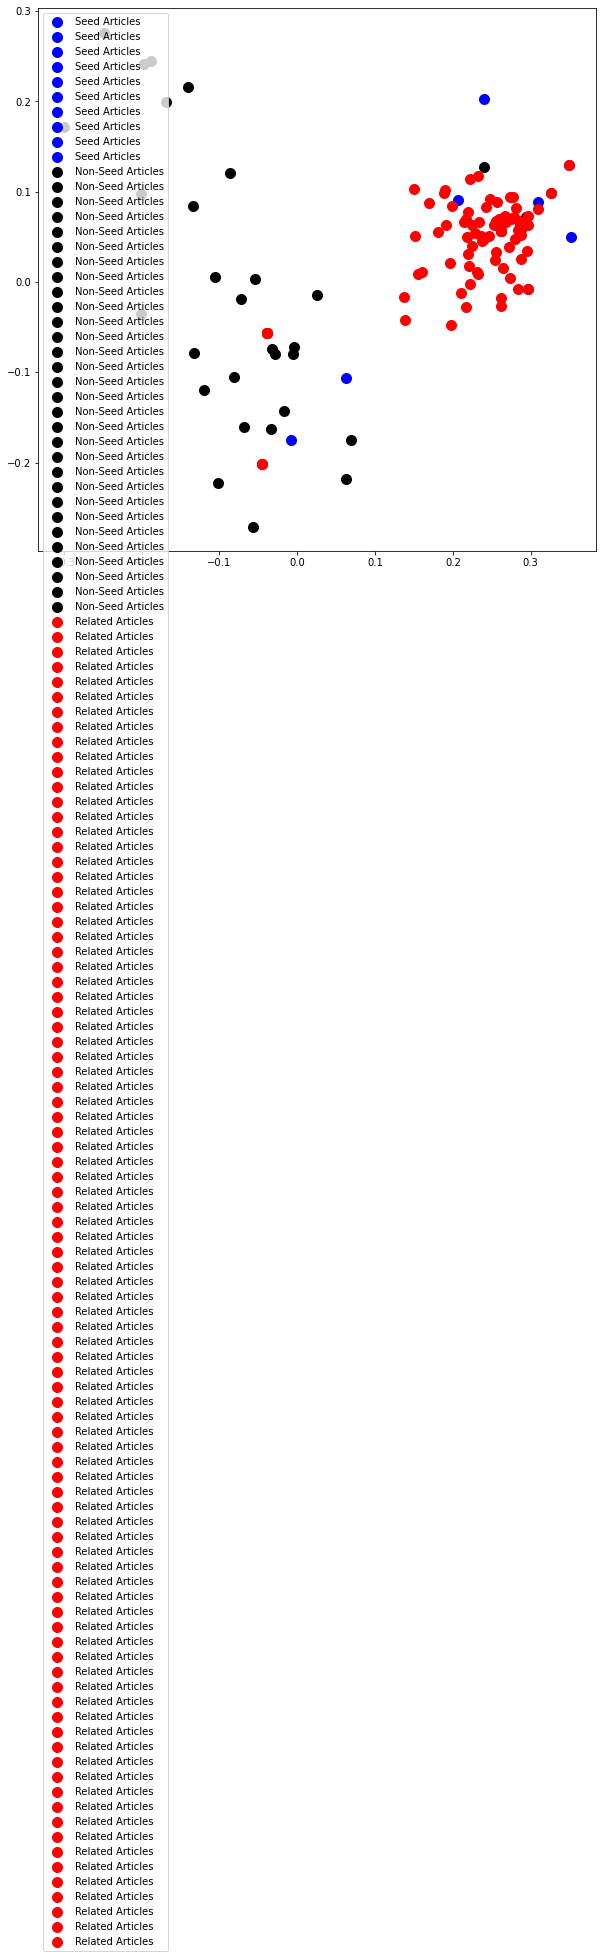

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
for article in articles2d[:len(seed_articles)]:
    ax.scatter(article[0], article[1], s=100, c="b", label="Seed Articles")
for article in articles2d[len(seed_articles):]:        
    ax.scatter(article[0], article[1], s=100, c="k", label="Non-Seed Articles")
for article in related_articles2d:
    ax.scatter(article[0], article[1], s=100, c="r", label="Related Articles")
ax.legend()


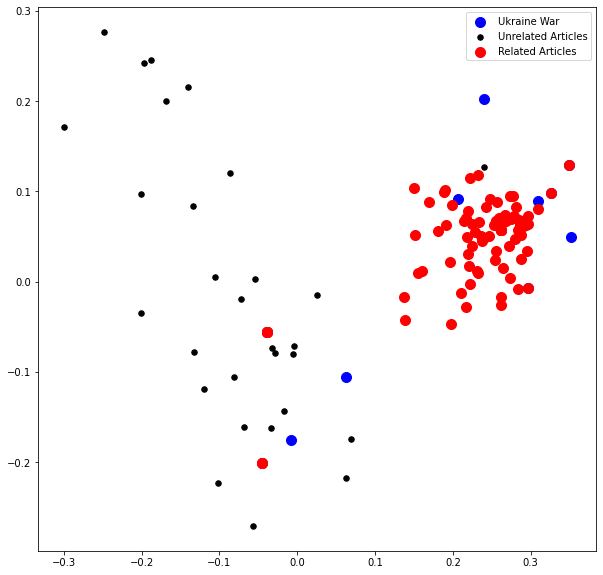

In [96]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(articles2d[:len(seed_articles), 0], articles2d[:len(seed_articles), 1], s=100, c="b", label=cluster_topic)
ax.scatter(articles2d[len(seed_articles):, 0], articles2d[len(seed_articles):, 1], s=30, c="k", label="Unrelated Articles")
ax.scatter(related_articles2d[:, 0], related_articles2d[:, 1], s=100, c="r", label="Related Articles")
ax.legend()

In [97]:
# Get distance of related embeddings from average cluster embedding
related_distances = np.sqrt(np.sum((cluster_av - related_news_embeddings)**2, axis=1))
other_distances = np.sqrt(np.sum((cluster_av - X)**2, axis=1))

In [100]:
related_distances.mean()

0.5457088473259554

In [101]:
other_distances.mean()

0.6746468456346545

In [107]:
new_articles_embedding = np.concatenate([X, related_news_embeddings])

In [108]:
pca = PCA(n_components=2)
new_articles2d = pca.fit_transform(new_articles_embedding)

In [112]:
# Get DBSCAN of all articles
new_clustering = DBSCAN(eps=0.65, min_samples=3).fit(new_articles_embedding)

In [113]:
new_clustering.labels_

array([-1,  0,  0,  1, -1,  0,  0, -1,  1,  0, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  2,  0,  2, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  2,  1,  0,  0,  0,  0, -1,  0,  0,  2,  0, -1,  0,  0,
        2,  0,  0,  2,  0,  0,  0,  0, -1, -1])

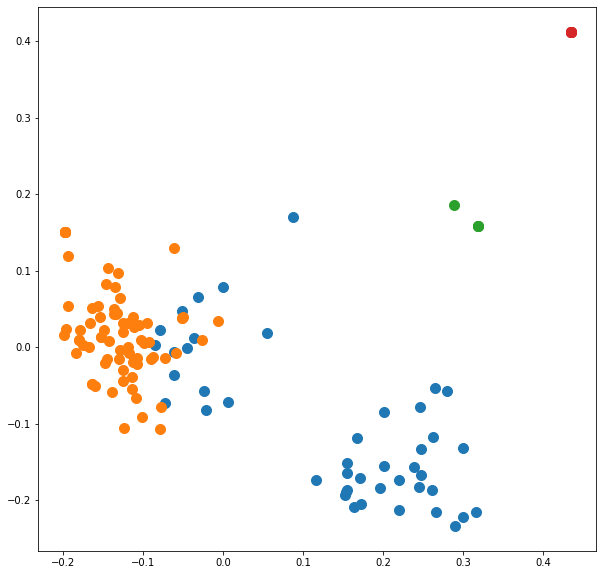

In [114]:
fig, ax = plt.subplots(figsize=(10,10))
for label in np.unique(clustering.labels_):
    article_list = new_articles2d[new_clustering.labels_ == label]
    ax.scatter(article_list[:, 0], article_list[:, 1], s=100)

In [118]:
# Find the new_cluster_label that most corresponds to the original cluster_label = 0 
# 1. 



In [123]:
clustering.labels_ == 0

array([False,  True,  True, False, False,  True,  True, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False])

In [131]:
overlap_labels = new_clustering.labels_[:len(clustering.labels_)][clustering.labels_ == 0]

In [135]:
most_overlap_cluster = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=overlap_labels)

In [136]:
print(f"The most overlapping cluster is {most_overlap_cluster}")

The most overlapping cluster is 0


Now we have a full set of well-clustered and well-populated articles on a topic. This is our "Storyline". Now we need to process it for easy consumption.

In [154]:
new_articles_embedding[0]

array([-0.01820301,  0.01797747, -0.00509346, ...,  0.0209001 ,
       -0.02302394, -0.02191504])

In [157]:
all_articles_dict = [article.__dict__ for article in all_articles]

In [161]:
for i, article in enumerate(all_articles_dict):
    article["embedding"] = new_articles_embedding[i]
    article["2d"] = new_articles2d[i]

In [165]:
storyline_articles = [article for article in all_articles_dict if new_clustering.labels_[all_articles_dict.index(article)] == most_overlap_cluster]

In [175]:
# Remove storyline articles that don't have a publish date
storyline_articles = [article for article in storyline_articles if article["publish_date"] is not None]
print(f"Found {len(storyline_articles)} storyline articles")

Found 67 storyline articles


In [187]:
# import datetime
from datetime import datetime as dt 
import datetime

In [182]:
# Convert all publish dates to offset-naive datetimes
for article in storyline_articles:
    article["publish_date"] = article["publish_date"].replace(tzinfo=None)

First, organise by publish date

In [ ]:
# Sort storyline_articles by publish_date
storyline_articles = sorted(storyline_articles, key=lambda x: x["publish_date"])

In [185]:
for article in storyline_articles:
    print(f"{article['title']} ({article['publish_date']})")
    print("")

Russia-Ukraine war: What happened today (March 9) (2022-03-09 00:00:00)

What Happened on Day 14 of Russia’s Invasion of Ukraine (2022-03-09 00:00:00)

How to end the war in Ukraine (2022-03-09 21:44:22)

Will the Russia-Ukraine war lead to World War III? And 2 other big questions, explained (2022-03-10 00:00:00)

‘No off-ramps’: U.S. and European officials don’t see a clear endgame in Ukraine (2022-03-10 00:00:00)

Opinion | The Ukraine War and the Retro-Future (2022-03-12 00:00:00)

Russia-Ukraine war military dispatch: March 12, 2022 (2022-03-12 00:00:00)

In Putin’s War on Ukraine, Expect the Unexpected - The New York Times (2022-03-15 00:00:00)

What Ukraine war news looks like from Russia (2022-03-15 00:00:00)

Biden calls Putin a 'war criminal'; NATO chief demands Russia stop the war (2022-03-16 00:00:00)

Live updates: Ukraine, Russia continue talks over video (2022-03-16 06:16:03)

U.S. citizen killed in Chernihiv; strike near Kharkiv leaves at least 23 dead (2022-03-17 00:00:

Now, would like to compare two contextually different articles from a time period. 

In [192]:
from sklearn.cluster import KMeans

In [190]:
# Build a TimeView
# 1. Get all articles from the latest week
# 2. Cluster those article embeddings with KMeans into 2 clusters
# 3. Get the two most "Representative articles" from each cluster
# 4. Ask GPT-3 to compare the two articles

# 1. 
week_start = dt.now() - datetime.timedelta(days=7)
week_end = dt.now()
weekview_articles = [article for article in storyline_articles if article["publish_date"] >= week_start and article["publish_date"] <= week_end]

In [194]:
# 2
weekview_embeddings = [article["embedding"] for article in weekview_articles]
weekview2d = pca.transform(weekview_embeddings)
weekview_embeddings = np.stack(weekview_embeddings)
weekview_clustering = KMeans(n_clusters=2).fit(weekview_embeddings)

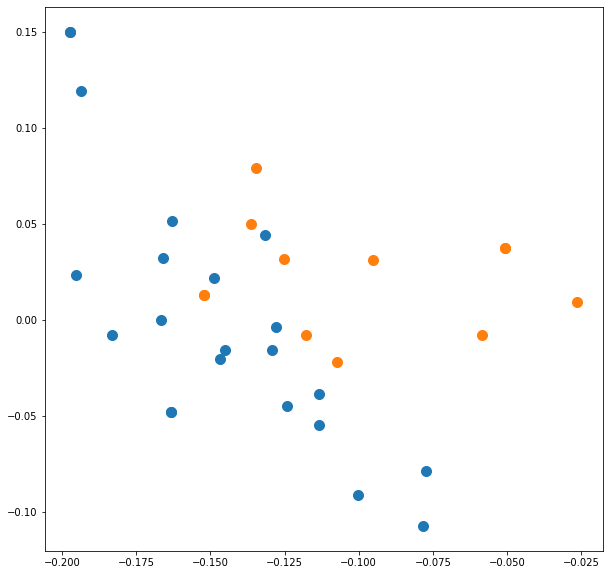

In [195]:
# Plot the weekview 2d embeddings
fig, ax = plt.subplots(figsize=(10,10))
for label in np.unique(weekview_clustering.labels_):
    article_list = weekview2d[weekview_clustering.labels_ == label]
    ax.scatter(article_list[:, 0], article_list[:, 1], s=100)

In [200]:
# 3. 
cluster0_mean = weekview_embeddings[weekview_clustering.labels_ == 0].mean(axis=0)
cluster0_distances = np.sqrt(np.sum((weekview_embeddings - cluster0_mean)**2, axis=1))
cluster0_representative_article = weekview_articles[np.argmin(cluster0_distances)]

In [203]:
def get_representative(cluster_embeddings, cluster_labels, cluster_articles, target_label):
    cluster_mean = cluster_embeddings[cluster_labels == target_label].mean(axis=0)
    cluster_distances = np.sqrt(np.sum((cluster_embeddings - cluster_mean)**2, axis=1))
    cluster_representative_article = cluster_articles[np.argmin(cluster_distances)]
    return cluster_representative_article

In [204]:
cluster0_representative_article = get_representative(weekview_embeddings, weekview_clustering.labels_, weekview_articles, 0)
cluster1_representative_article = get_representative(weekview_embeddings, weekview_clustering.labels_, weekview_articles, 1)

In [216]:
print(cluster0_representative_article["source_url"])
print(cluster1_representative_article["source_url"])

https://www.washingtonpost.com
https://www.aljazeera.com


In [231]:
def get_comparison(input_text, engine="text-davinci-002"):
    return openai.Completion.create(
        engine=engine,
        prompt=input_text,
        max_tokens=256,
        temperature=0.8,
    )

In [241]:
# Using gpt-3, ask GPT-3 to compare the two articles
article_0_subset = " ".join(cluster0_representative_article["text"].replace("\n", " ").split(" ")[:300])
article_1_subset = " ".join(cluster1_representative_article["text"].replace("\n", " ").split(" ")[:300])

input_text = "Article 1: \n\n" + article_0_subset + "\n\nArticle 2: \n\n" + article_1_subset + "\n\nCompare the sentiment, context and political bias of these two articles."

comparison = get_comparison(input_text)["choices"][0]["text"].replace("\n", "")


In [243]:
print(f"This is the comparison we get from GPT-3: \n\n{comparison}")

This is the comparison we get from GPT-3: 

The first article is about the war in Ukraine, and the second article is about Russia's goals in the war. The first article is neutral in tone, while the second article is critical of Russia. The first article provides context about the war, while the second article provides analysis of Russia's goals. The first article is unbiased, while the second article has a political bias against Russia.
